# Mental Health Interference at Work Using Machine Learning

Contributors: Orvin Bellamy, Isha Goyal, Elodie Garguilo

Python Version 3.8.8

Dataset by Open Sourcing Mental Illness, LTD\
https://www.kaggle.com/osmi/mental-health-in-tech-survey \
https://osmihelp.org/about/about-osmi

Refer to the kaggle page for the data dictionary of this dataset

Objective:\
This machine learning model is used to predict whether employees' mental health conditions interfere with their work based on OSMI's survey filled by employees. Features derived from the employee's and company's profile are used against the 'work_interfere' variable as label.

Note that given the small dataset size, labels classes have to be collapsed into 2 (binary) classes. More information about data preprocessing can be read below.

Some data discoveries and visualziation is done via simple Tableau bar charts available as a Tableau Workbook & .ppt file in this git.

# Import Packages

In [1]:
# Import Packages

# For pre-processing
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

# For building models
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier

#For accessing models 
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Pre-processing


In [2]:
# Reading the dataset
df = pd.read_csv('survey.csv')
# df.head()

Dataset discovery, uncomment to use

In [ ]:
# print("Different age groups: \n")
# print(df['Age'].unique())
# print("\n \n \n")
# print("Different gender notations are: \n")
# print(df['Gender'].unique())

Note that there are faulty data entries in the 'Age' column. Observations with age older than 100 or younger than 15 years old are removed.

Data entry for 'Gender' is also not controlled. Gender is not used as Feature in the original model, but it has been cleaned into two classes ('Male', 'Female') in case it will be used in the future.

In [3]:
# Fixing the Age and Gender columns
df.drop(df[df['Age'] > 100].index, inplace = True)
df.drop(df[df['Age'] < 15].index, inplace = True)

df['Gender'].replace(['Male ', 'male', 'Man', 'cis male','Male', 'Cis Male',
                      'M', 'm', 'Mail', 'Malr', 'Mal', 'Male (CIS)',
                      'Cis Man', 'msle', 'Male-ish', 'maile', 'Make',], 'Male', inplace = True)

df['Gender'].replace(['Female ', 'female', 'femail', 'Cis Female', 'Woman', 'Female',
                     'F', 'f', 'cis-female/femme', 'Femake', 'Female (cis)',
                     'woman',], 'Female', inplace = True)

df['Gender'].replace( ['Female (trans)', 'fluid', 'queer', 'non-binary',
                      'queer/she/they','Androgyne', 'Trans-female', 'male leaning androgynous',
                     'ostensibly male, unsure what that really means',
                      'Agender', 'A little about you', 'Nah', 'All',
                      'Guy (-ish) ^_^', 'Trans woman',
                      'Genderqueer', 'Enby', 'p', 'Neuter', 'something kinda male?', ],'Other',inplace = True)

Removing variables not used for features. Edit the code below to include/exclude variables to be used for features.

In [4]:
df.drop(['Timestamp', 'Age', 'Gender', 'Country', 'state', 'self_employed',
        'no_employees', 'seek_help', 'care_options',
        'tech_company',  'leave', 'phys_health_consequence', 'coworkers',
        'mental_health_interview', 'phys_health_interview',
       'mental_vs_physical', 'comments'],axis = 1, inplace = True)

In [5]:
df.columns

Index(['family_history', 'treatment', 'work_interfere', 'remote_work',
       'benefits', 'wellness_program', 'anonymity',
       'mental_health_consequence', 'supervisor', 'obs_consequence'],
      dtype='object')

Dropping null values

In [6]:
# dropping the null values
df.dropna(inplace = True)

Note that the label 'work_interfere' used in this model has 4 classes ('Often', 'Sometimes', 'Rarely', 'Never'. 'NA' are dropped because it is assumed respondents who pick 'NA' do not claim to have mental health condition), which doesn't produce good predictive power. This is likely attributed to insufficient training data.

Another model is built with the label 'work_interfere' collapsed into 2 classes ('Yes' = 'Often', 'Sometimes'; 'No' = 'Rarely', 'Never').

df --> original label\
df_bin --> binned label

In [7]:
# Creating a dataframe copy for binning
df_bin = df.copy(deep=True)
df_bin.loc[df_bin['work_interfere'] == "Often", 'work_interfere'] = "Yes"
df_bin.loc[df_bin['work_interfere'] == "Sometimes", 'work_interfere'] = "Yes"
df_bin.loc[df_bin['work_interfere'] == "Rarely", 'work_interfere'] = "No"
df_bin.loc[df_bin['work_interfere'] == "Never", 'work_interfere'] = "No"

In [8]:
df_bin.dropna(inplace = True)

Splitting data for training and testing. Random_state is fixed for reproducibility, recommend removing random_state to simulate model performance multiple times.

In [9]:
# Splitting the dataset before processing to follow The Golden Rule
train_df, test_df = train_test_split(df, test_size=0.25, random_state=99)
X_train = train_df.drop(columns=["work_interfere"])
y_train = train_df["work_interfere"]
X_test = test_df.drop(columns=["work_interfere"])
y_test = test_df["work_interfere"]

In [10]:
# Splitting for the binned dataset
train_df_bin, test_df_bin = train_test_split(df_bin, test_size=0.25, random_state=99)
X_train_bin = train_df_bin.drop(columns=["work_interfere"])
y_train_bin = train_df_bin["work_interfere"]
X_test_bin = test_df_bin.drop(columns=["work_interfere"])
y_test_bin = test_df_bin["work_interfere"]

Preprocessing pipeline

col_transformer is for normal label\
col_transformer_bin is for binned label

In [11]:
# creating the column tansformer
categorical_features = X_train.select_dtypes('object').columns

In [12]:
categorical_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="constant",fill_value="missing")),
           ("onehot", OneHotEncoder(sparse=False, handle_unknown='ignore'))]
)

In [13]:
col_transformer = ColumnTransformer(
    transformers=[
        ("categorical", categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)

In [14]:
# Column Transformer for the binned dataset
categorical_features_bin = X_train_bin.select_dtypes('object').columns

categorical_transformer_bin = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="constant",fill_value="missing")),
           ("onehot", OneHotEncoder(sparse=False, handle_unknown='ignore'))]
)

col_transformer_bin = ColumnTransformer(
    transformers=[
        ("categorical", categorical_transformer_bin, categorical_features_bin)
    ],
    remainder='passthrough'
)

# Model

Dummy model

In [15]:
# Create a dummy model for normal label and binary label

dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train, y_train)

dummy_bin = DummyClassifier(strategy='most_frequent')
dummy_bin.fit(X_train_bin, y_train_bin)

print("Normal label score: ", dummy.score(X_test, y_test))
print("Binary label score: ", dummy_bin.score(X_test_bin, y_test_bin))

Normal label score:  0.4838709677419355
Binary label score:  0.6169354838709677


3 pipelines for hyperparameter optimization

1 pipeline for normal labels (SVC), 2 pipelines for binned labels (SVC, decision tree)

In [16]:
# Create pipelines for hyperparameter optimization

## For normal labels
pipe_sv = Pipeline(
    steps=[('columntransformer', col_transformer),
           ('svc', SVC())]
)

## For binary labels
pipe_sv_bin = Pipeline(
    steps=[('columntransformer', col_transformer_bin),
           ('svc', SVC())]
)

pipe_dt_bin = Pipeline(
    steps=[('columntransformer', col_transformer_bin),
           ('dtc', DecisionTreeClassifier())]
)

Model for Normal Labels

In [17]:
# Create an SVC model

# set a param
param = {'svc__gamma': [0.01, 0.1, 1, 10, 100, 1000], 'svc__C': [0.01, 0.1, 1, 10, 100, 1000]}

# Set random_search
# model should be changed to pipe
sv_grid = GridSearchCV(pipe_sv, param, cv=10, n_jobs=-1, return_train_score=True)
sv_grid.fit(X_train, y_train)

sv_grid_result = pd.DataFrame(sv_grid.cv_results_)[["params", "mean_test_score", "mean_train_score", "rank_test_score"]].sort_values(by='rank_test_score')

# get best parameter
svc_gamma = sv_grid.best_params_['svc__gamma']
svc_C = sv_grid.best_params_['svc__C']

# Create new pipeline with optimized hyperparameter
svc = Pipeline(
    steps=[('columntransformer', col_transformer),
          ('svc', SVC(gamma=svc_gamma, C=svc_C))]
)

# # Train and test the model
svc.fit(X_train, y_train)
svc_testscore = svc.score(X_test, y_test)
print('SVC test score: ', svc_testscore)

SVC test score:  0.5645161290322581


In [ ]:
# Uncomment the line below to see the grid search result
# sv_grid_result

Model for binary labels

In [18]:
# Create a decision tree classifier

# Set param_grid
param_grid = {'dtc__min_samples_split': list(range(10, 101))}

# Do gridsearchCV
dt_grid_bin = GridSearchCV(pipe_dt_bin, param_grid, cv=10, n_jobs=-1, return_train_score=True)
dt_grid_bin.fit(X_train_bin, y_train_bin)

dt_grid_bin_result = pd.DataFrame(dt_grid_bin.cv_results_)[["params", "mean_test_score", "mean_train_score", "rank_test_score"]].sort_values(by='rank_test_score')
#dt_grid_result

# get best parameter
hp_min_split_bin = dt_grid_bin.best_params_['dtc__min_samples_split']
#hp_min_split

# Create new pipeline with optimized hyperparameter
dec_tree_bin = Pipeline(
    steps=[('columntransformer', col_transformer_bin),
           ('dtc', DecisionTreeClassifier(min_samples_split=hp_min_split_bin))]
)

# # Train and test the model
dec_tree_bin.fit(X_train_bin, y_train_bin)
dec_tree_bin_testscore = dec_tree_bin.score(X_test_bin, y_test_bin)
print('Dec tree test score: ', dec_tree_bin_testscore)

Dec tree test score:  0.7379032258064516


In [ ]:
# Uncomment the line below to see the grid search result
# dt_grid_bin

In [19]:
# Create an SVC model

# set a param
param = {'svc__gamma': [0.01, 0.1, 1, 10, 100, 1000], 'svc__C': [0.01, 0.1, 1, 10, 100, 1000]}

# Set random_search
# model should be changed to pipe
sv_grid_bin = GridSearchCV(pipe_sv_bin, param, cv=10, n_jobs=-1, return_train_score=True)
sv_grid_bin.fit(X_train_bin, y_train_bin)

sv_grid_bin_result = pd.DataFrame(sv_grid_bin.cv_results_)[["params", "mean_test_score", "mean_train_score", "rank_test_score"]].sort_values(by='rank_test_score')

# get best parameter
svc_gamma_bin = sv_grid_bin.best_params_['svc__gamma']
svc_C_bin = sv_grid_bin.best_params_['svc__C']

# Create new pipeline with optimized hyperparameter
svc_bin = Pipeline(
    steps=[('columntransformer', col_transformer_bin),
           ('svc', SVC(gamma=svc_gamma_bin, C=svc_C_bin))]
)

# # Train and test the model
svc_bin.fit(X_train_bin, y_train_bin)
svc_bin_testscore = svc_bin.score(X_test_bin, y_test_bin)
print('SVC test score: ', svc_bin_testscore)

SVC test score:  0.7379032258064516


In [ ]:
# Uncomment the line below to see the grid search result
# sv_grid_bin_result

Note that for the binned label, the two models svc_bin and dec_tree_bin produces the exact same test score. This is tested for multiple random_state when splitting the data. No explanation for this phenomenon yet, will investigate further.

## Model Evaluation

Model Evaluation : SVC

In [ ]:
# confusion matrix to visualize the performance of the algorithm.
predictions_svc = svc.predict(X_test)
cm_svc = confusion_matrix(y_test, predictions_svc)
# cm_svc

array([[38,  0,  0,  6],
       [ 4,  0,  0, 34],
       [12,  0,  0, 31],
       [32,  0,  0, 91]])

Note the confusion matrix below. The model only predicts "Sometimes" and "Never". This is likely attributed to the small training data. An experiment was done where all observations where 'work_interfere' = 'Sometimes' is removed and all the remaining classes can be predicted. This is another reason why collapsing the label into 2 classes is preferred.

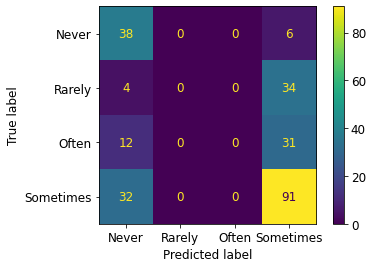

In [ ]:
# Confusion Matrix plot 

plt.rc('font', size=12) # bigger font sizes
ConfusionMatrixDisplay(cm_svc, display_labels=["Never","Rarely","Often","Sometimes"]).plot()

In [ ]:
# Classification Report  
print(classification_report(
        y_test,
        svc.predict(X_test),digits=4,
        target_names=["Never", "Rarely", "Often","Sometimes"]))

              precision    recall  f1-score   support

       Never     0.4419    0.8636    0.5846        44
      Rarely     0.0000    0.0000    0.0000        38
       Often     0.0000    0.0000    0.0000        43
   Sometimes     0.5617    0.7398    0.6386       123

    accuracy                         0.5202       248
   macro avg     0.2509    0.4009    0.3058       248
weighted avg     0.3570    0.5202    0.4204       248



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Check for classification balance
y_train.value_counts('work_interfere')

Sometimes    0.460189
Never        0.226721
Rarely       0.175439
Often        0.137652
Name: work_interfere, dtype: float64

### Model Evaluation : Dec Tree Bin

In [ ]:
# confusion matrix to visualize the performance of the algorithm.
predictions_dt = dec_tree_bin.predict(X_test_bin)
cm_dt = confusion_matrix(y_test_bin, predictions_dt)
cm_dt

array([[ 46,  50],
       [ 22, 130]])

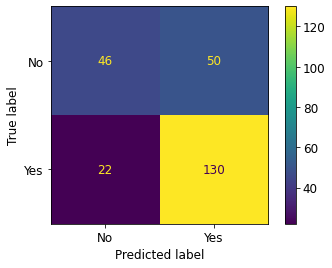

In [ ]:
# Confusion Matrix plot 

plt.rc('font', size=12) # bigger font sizes
ConfusionMatrixDisplay(cm_dt, display_labels=["No", "Yes"]).plot()

In [ ]:
# Classification Report  - Dec Tree Model
print(classification_report(
        y_test_bin,
        dec_tree_bin.predict(X_test_bin),digits=4,
        target_names=["No", "Yes"]))

              precision    recall  f1-score   support

          No     0.6765    0.4792    0.5610        96
         Yes     0.7222    0.8553    0.7831       152

    accuracy                         0.7097       248
   macro avg     0.6993    0.6672    0.6721       248
weighted avg     0.7045    0.7097    0.6971       248



### Model Evaluation : SVC_bin

In [ ]:
# confusion matrix on SVC_bin to visualize the performance of the algorithm.svc_bin.fit(X_train_bin, y_train_bin)
predictions = svc_bin.predict(X_test_bin)
cm = confusion_matrix(y_test_bin, predictions)
cm

array([[ 46,  50],
       [ 22, 130]])

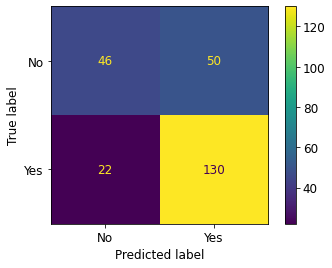

In [ ]:
# Confusion Matrix plot SVC_bin

plt.rc('font', size=12) # bigger font sizes
ConfusionMatrixDisplay(cm, display_labels=["No", "Yes"]).plot()

In [ ]:
# Classification Report  - SVC_bin Model
print(classification_report(
        y_test_bin,
        svc_bin.predict(X_test_bin),digits=4,
        target_names=["No", "Yes"]))

              precision    recall  f1-score   support

          No     0.6765    0.4792    0.5610        96
         Yes     0.7222    0.8553    0.7831       152

    accuracy                         0.7097       248
   macro avg     0.6993    0.6672    0.6721       248
weighted avg     0.7045    0.7097    0.6971       248



In [ ]:
# Check for classification balance
y_train_bin.value_counts('work_interfere')

Yes    0.609987
No     0.390013
Name: work_interfere, dtype: float64